In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn import linear_model
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier, PassiveAggressiveClassifier, Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

np.random.seed(1234)

In [83]:
dataset = pd.read_csv("ADNI_ALL.csv")

In [84]:
observation = dataset[(dataset.DX == 'Dementia') & (dataset.VISCODE == 'bl') & (dataset.DX_bl != 'AD')]
dataset = dataset.drop(observation.index)
dataset.loc[dataset.DX == 'Dementia', 'DX'] = 'AD'

dataset.loc[dataset['DX_bl'].isin(['EMCI', 'LMCI']), 'DX_bl'] = 'MCI'
dataset.loc[dataset['DX_bl'] == 'SMC', 'DX_bl'] = 'CN'

observation_AD_MCI = dataset[(dataset['DX_bl'] == 'AD') & (dataset['DX'] == 'MCI') & (dataset.VISCODE == 'bl')]
observation_MCI_CN = dataset[(dataset['DX_bl'] == 'MCI') & (dataset['DX'] == 'CN') & (dataset.VISCODE == 'bl')]
observation = pd.concat([observation_AD_MCI, observation_MCI_CN, observation])

dataset = dataset.drop(observation_AD_MCI.index)
dataset = dataset.drop(observation_MCI_CN.index)

In [85]:
adni1 = dataset[dataset['ORIGPROT'] == 'ADNI1'].copy()
adni2 = dataset[dataset['ORIGPROT'] == 'ADNI2'].copy()
adni3 = dataset[dataset['ORIGPROT'] == 'ADNI3'].copy()
adnigo = dataset[dataset['ORIGPROT'] == 'ADNIGO'].copy()

In [86]:
df = adni1[adni1['M'] == 0] 

protein_features = ['TAU', 'ABETA', 'PTAU']

for i in protein_features:
    all = df[i].values
    df = df.drop(i, axis=1)
    df[i] = [float(str(x).replace('<','').replace('>','')) for x in all]

drop_features1 = ['DX_bl', 'M', 'VISCODE', 'update_stamp', 'Month']
drop_features2 = ['RID', 'PTID', 'SITE', 'ORIGPROT', 'COLPROT', 'FSVERSION', 'IMAGEUID', 'FLDSTRENG', 'EXAMDATE']

baseline_features = []
nulls = dict(df.isna().sum().sort_values())
null_columns = []


for i in df.columns.values:
    if '_bl' in i or '_BL' in i:
        baseline_features.append(i)
    elif nulls[i] > df.shape[0]/1.1:
        baseline_features.append(i)
        
df = df.drop(drop_features1 + drop_features2 + baseline_features + null_columns, axis=1)

In [87]:
df['PTGENDER'] = (df['PTGENDER'] == 'Female')*1

categorical_features = ['PTETHCAT', 'PTRACCAT', 'PTMARRY']
dummy_featues = pd.get_dummies(df[categorical_features])
df = pd.concat([df, dummy_featues], axis=1)

df = df.rename(index=str, columns={"PTGENDER": "PTGENDER_Female"})
df = df.drop(categorical_features, axis=1)
df = df.dropna(subset=['DX'])
df['DX'] = df['DX'].map({'CN': 1, 'MCI': 2, 'AD': 3})

In [88]:
# Imputation

blank_df = pd.DataFrame(df.isna().sum().sort_values(), columns=['Nulls'])
new_blank_values = blank_df[blank_df['Nulls'] > 0].to_dict()['Nulls']
blank_values = new_blank_values.keys()
not_empty_values = df.columns.difference(blank_values).values
dict1 = {}

random_value = -247
df = df.fillna(random_value)

for i, column in enumerate(blank_values):
    
    train = df[df[column] != random_value]
    x = train[train.columns.difference([column, 'DX'])]
    y = train[column]    
   
    test = df[df[column] == random_value]
    x_tes = test[test.columns.difference([column, 'DX'])]
    y_tes = test[column]   
    
    model = KNeighborsRegressor(n_neighbors=5).fit(x, y)
    
    index1 = df[df[column] == random_value][column].index.values
    dict1[column] = model.predict(x_tes)
    
for column in blank_values:
    index1 = df[df[column] == random_value][column].index.values
    df.loc[index1, column] = dict1[column]

In [89]:
df.columns

Index(['AGE', 'PTGENDER_Female', 'PTEDUCAT', 'APOE4', 'FDG', 'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'LDELTOTAL', 'DIGITSCOR', 'TRABSCOR', 'FAQ', 'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV', 'DX', 'mPACCdigit', 'mPACCtrailsB', 'TAU', 'ABETA', 'PTAU', 'PTETHCAT_Hisp/Latino', 'PTETHCAT_Not Hisp/Latino', 'PTETHCAT_Unknown', 'PTRACCAT_Am Indian/Alaskan',
       'PTRACCAT_Asian', 'PTRACCAT_Black', 'PTRACCAT_More than one', 'PTRACCAT_White', 'PTMARRY_Divorced', 'PTMARRY_Married', 'PTMARRY_Never married', 'PTMARRY_Unknown', 'PTMARRY_Widowed'],
      dtype='object')

In [91]:
X = df[df.columns.difference(['DX'])]
Y = df['DX']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state= 42)

In [92]:
X_train2 = X_train[['MMSE', 'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'DIGITSCOR', 'TRABSCOR', 'FAQ', 'mPACCdigit', 'mPACCtrailsB', 'LDELTOTAL']]
X_test2 = X_test[['MMSE', 'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting',  'DIGITSCOR', 'TRABSCOR', 'FAQ', 'mPACCdigit', 'mPACCtrailsB', 'LDELTOTAL']]

In [93]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score

from mlxtend.feature_selection import SequentialFeatureSelector

feature_selector = SequentialFeatureSelector(RandomForestClassifier(n_jobs=-1), k_features=5, forward=True, verbose=2, cv=4)

In [94]:
features = feature_selector.fit(np.array(X_train2), y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   17.7s finished

[2022-04-30 12:03:11] Features: 1/5 -- score: 0.8929747119557085[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:   15.2s finished

[2022-04-30 12:03:26] Features: 2/5 -- score: 0.9266141702828071[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:   14.2s finished

[2022-04-30 12:03:40] Features: 3/5 -- score: 0.9250991321262906[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 

In [95]:
filtered_features= X_train2.columns[list(features.k_feature_idx_)]
filtered_features

Index(['MMSE', 'CDRSB', 'RAVLT_immediate', 'TRABSCOR', 'LDELTOTAL'], dtype='object')

In [96]:
X_train2 = X_train[['MMSE', 'CDRSB', 'RAVLT_immediate', 'DIGITSCOR', 'LDELTOTAL']]
X_test2 = X_test[['MMSE', 'CDRSB', 'RAVLT_immediate', 'DIGITSCOR', 'LDELTOTAL']]

In [97]:
def model_evaluation(X_train2, y_train, model):
    model.fit(X_train2, y_train)
    preds = model.predict(X_test2)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X_train2, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    difference = scores.mean() - model.score(X_test2, y_test)
    Standard_deviation = difference / scores.std()
    Hamming_Loss = metrics.hamming_loss(y_test, preds)
    Jaccard_Index = metrics.jaccard_score(y_test, preds, average='micro')
    Accuracy = metrics.accuracy_score(y_test, preds)
    MCC = matthews_corrcoef(y_test, preds)

    print(f"Training Score:{model.score(X_train2, y_train)}")
    print(f"Cross V Score: {scores.mean()} +/- {scores.std()}")
    print(f"Testing Score: {model.score(X_test2, y_test)}")
    print(f"Cross & Test Diff: {difference}")
    print(f"Standard Deviation: {Standard_deviation}")
    print(confusion_matrix(y_test, preds))
    print(classification_report(y_test, preds))
    print(f"Hamming Loss: {Hamming_Loss}")
    print(f"Jaccard Score: {Jaccard_Index}")
    print(f"MCC: {MCC}")
    print(f"Accuracy: {Accuracy}")
    print("Overall Accuracy:",accuracy_score(y_test, preds))
    print("Balanced Accuracy:",balanced_accuracy_score(y_test, preds))
    print("Overall Precision:",precision_score(y_test, preds, average='weighted'))
    print("Overall Recall:",recall_score(y_test, preds, average='weighted'))
    print("Overall Precision, Recall, F-measure:",precision_recall_fscore_support(y_test, preds, average='weighted'))

In [98]:
def plot_model(model):
    predict = model.predict_proba(X_test2)
    classes = ['CN', 'MCI', 'AD']  
    fpr = {}
    tpr = {}
    thresh ={}
    for i in range(len(classes)):    
        fpr[i], tpr[i], thresh[i] = roc_curve(y_test, predict[:,i], pos_label=i)
        
    auc = roc_auc_score(y_test,predict, multi_class='ovr')
    print('Average AUC:', auc)
    log_loss = metrics.log_loss(y_test, predict)
    print(f"Log loss: {log_loss}")    

    plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label=classes[0] + ' vs Rest')
    plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label=classes[1] + ' vs Rest')
    plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label=classes[2] + ' vs Rest')
    plt.title('Multiclass ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    plt.show()

Training Score:0.8975535168195719
Cross V Score: 0.8771950271950274 +/- 0.06569375231373506
Testing Score: 0.9085365853658537
Cross & Test Diff: -0.03134155817082629
Standard Deviation: -0.47708582729675325
[[58  1  0]
 [ 0 64 12]
 [ 0  2 27]]
              precision    recall  f1-score   support

           1       1.00      0.98      0.99        59
           2       0.96      0.84      0.90        76
           3       0.69      0.93      0.79        29

    accuracy                           0.91       164
   macro avg       0.88      0.92      0.89       164
weighted avg       0.92      0.91      0.91       164

Hamming Loss: 0.09146341463414634
Jaccard Score: 0.8324022346368715
MCC: 0.8621382440195176
Accuracy: 0.9085365853658537
Overall Accuracy: 0.9085365853658537
Balanced Accuracy: 0.9187301977913808
Overall Precision: 0.9248410853798548
Overall Recall: 0.9085365853658537
Overall Precision, Recall, F-measure: (0.9248410853798548, 0.9085365853658537, 0.9119092090756367, None)
A

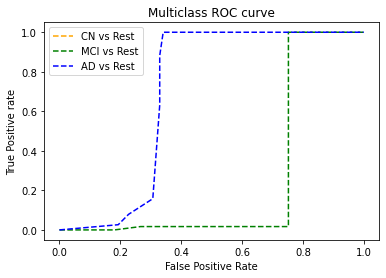

In [20]:
#AdaBoost

clf1 = AdaBoostClassifier(n_estimators=100, learning_rate=1.0, algorithm='SAMME.R', random_state=0)
model_evaluation(X_train2, y_train, clf1)
plot_model(clf1)

Training Score:0.9342507645259939
Cross V Score: 0.9296581196581197 +/- 0.025785120532258867
Testing Score: 0.9207317073170732
Cross & Test Diff: 0.008926412341046519
Standard Deviation: 0.3461846272884005
[[58  1  0]
 [ 0 72  4]
 [ 0  8 21]]
              precision    recall  f1-score   support

           1       1.00      0.98      0.99        59
           2       0.89      0.95      0.92        76
           3       0.84      0.72      0.78        29

    accuracy                           0.92       164
   macro avg       0.91      0.88      0.90       164
weighted avg       0.92      0.92      0.92       164

Hamming Loss: 0.07926829268292683
Jaccard Score: 0.8531073446327684
MCC: 0.8726976175731291
Accuracy: 0.9207317073170732
Overall Accuracy: 0.9207317073170732
Balanced Accuracy: 0.884852399848247
Overall Precision: 0.9202168021680217
Overall Recall: 0.9207317073170732
Overall Precision, Recall, F-measure: (0.9202168021680217, 0.9207317073170732, 0.9192578562238342, None)
Ave

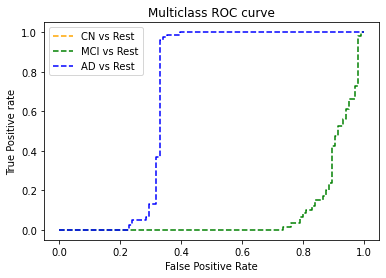

In [21]:
#ExtraTrees

clf2 = ExtraTreesClassifier(n_estimators=100, criterion='entropy', 
                             max_depth=5, min_samples_split=2, min_samples_leaf=2, 
                             min_weight_fraction_leaf=0.0, max_features='sqrt',
                             max_leaf_nodes=None, min_impurity_decrease=0.0, 
                             bootstrap=False, oob_score=False, 
                             n_jobs=4, random_state=None, verbose=0, warm_start=False, 
                             class_weight=None, ccp_alpha=0.0, max_samples=None)
model_evaluation(X_train2, y_train, clf2)
plot_model(clf2)

Training Score:1.0
Cross V Score: 0.9423776223776225 +/- 0.023964805098368583
Testing Score: 0.9451219512195121
Cross & Test Diff: -0.002744328841889687
Standard Deviation: -0.11451496603560982
[[58  1  0]
 [ 0 73  3]
 [ 0  5 24]]
              precision    recall  f1-score   support

           1       1.00      0.98      0.99        59
           2       0.92      0.96      0.94        76
           3       0.89      0.83      0.86        29

    accuracy                           0.95       164
   macro avg       0.94      0.92      0.93       164
weighted avg       0.95      0.95      0.94       164

Hamming Loss: 0.054878048780487805
Jaccard Score: 0.8959537572254336
MCC: 0.9119532758618456
Accuracy: 0.9451219512195121
Overall Accuracy: 0.9451219512195121
Balanced Accuracy: 0.9237211233812176
Overall Precision: 0.9451562553600218
Overall Recall: 0.9451219512195121
Overall Precision, Recall, F-measure: (0.9451562553600218, 0.9451219512195121, 0.9447558910186762, None)
Average AUC: 

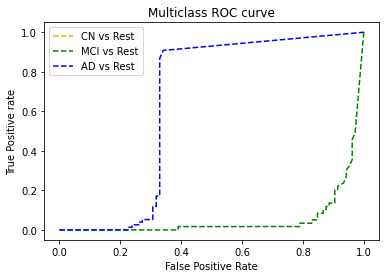

In [22]:
#RandomForest

clf3 = RandomForestClassifier(n_estimators=1000, criterion='gini', 
                               max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                               min_weight_fraction_leaf=0.0, max_features='auto', 
                               max_leaf_nodes=None, min_impurity_decrease=0.0, 
                               bootstrap=True, oob_score=False, n_jobs=None, random_state=None, 
                               verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
model_evaluation(X_train2, y_train, clf3)
plot_model(clf3)

[03:07:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Score:0.963302752293578
Cross V Score: 0.9357575757575758 +/- 0.029738486432343305
Testing Score: 0.9329268292682927
Cross & Test Diff: 0.0028307464892830536
Standard Deviation: 0.09518798126203086
[[58  1  0]
 [ 0 72  4]
 [ 0  6 23]]
              precision    recall  f1-score   support

           1       1.00      0.98      0.99        59
           2       0.91      0.95      0.93        76
           3       0.85      0.79      0.82        29

    accuracy                           0.93       164
   macro avg       0.92      0.91      0.91       164
weighted avg       0.93      0.93      0.93       164

Hamming Loss: 0.06707317073170732
Jaccard Score: 0.8742857142857

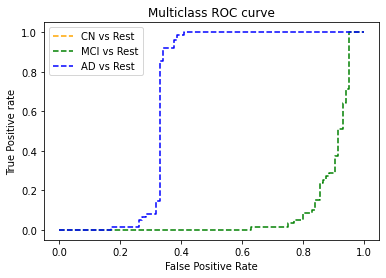

In [23]:
#XGB

clf4 = XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, objective='multi:softprob', num_class= 10,
                  n_estimators=100, max_depth=3)
model_evaluation(X_train2, y_train, clf4)
plot_model(clf4)

Training Score:0.9434250764525994
Cross V Score: 0.9291686091686092 +/- 0.029370859592179534
Testing Score: 0.926829268292683
Cross & Test Diff: 0.0023393408759262435
Standard Deviation: 0.07964836264271717
[[58  1  0]
 [ 0 72  4]
 [ 0  7 22]]
              precision    recall  f1-score   support

           1       1.00      0.98      0.99        59
           2       0.90      0.95      0.92        76
           3       0.85      0.76      0.80        29

    accuracy                           0.93       164
   macro avg       0.92      0.90      0.90       164
weighted avg       0.93      0.93      0.93       164

Hamming Loss: 0.07317073170731707
Jaccard Score: 0.8636363636363636
MCC: 0.8824668306798535
Accuracy: 0.926829268292683
Overall Accuracy: 0.926829268292683
Balanced Accuracy: 0.8963466527218102
Overall Precision: 0.926454033771107
Overall Recall: 0.926829268292683
Overall Precision, Recall, F-measure: (0.926454033771107, 0.926829268292683, 0.9259120283510529, None)
Average

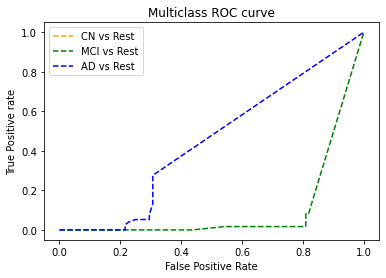

In [24]:
#DT

clf5 = DecisionTreeClassifier(criterion='gini', splitter='best', 
                               max_depth=8, min_samples_split=8, min_samples_leaf=8, 
                               min_weight_fraction_leaf=0.0, max_features=None, 
                               random_state=None, max_leaf_nodes=None, 
                               class_weight=None, ccp_alpha=0.0)
model_evaluation(X_train2, y_train, clf5)
plot_model(clf5)

Training Score:1.0
Cross V Score: 0.9046076146076147 +/- 0.03153331174110016
Testing Score: 0.9329268292682927
Cross & Test Diff: -0.028319214660677994
Standard Deviation: -0.8980729614824139
[[58  1  0]
 [ 0 71  5]
 [ 0  5 24]]
              precision    recall  f1-score   support

           1       1.00      0.98      0.99        59
           2       0.92      0.93      0.93        76
           3       0.83      0.83      0.83        29

    accuracy                           0.93       164
   macro avg       0.92      0.91      0.92       164
weighted avg       0.93      0.93      0.93       164

Hamming Loss: 0.06707317073170732
Jaccard Score: 0.8742857142857143
MCC: 0.892551169070574
Accuracy: 0.9329268292682927
Overall Accuracy: 0.9329268292682927
Balanced Accuracy: 0.914949193556656
Overall Precision: 0.9334019638897689
Overall Recall: 0.9329268292682927
Overall Precision, Recall, F-measure: (0.9334019638897689, 0.9329268292682927, 0.9331199646838098, None)
Average AUC: 0.939

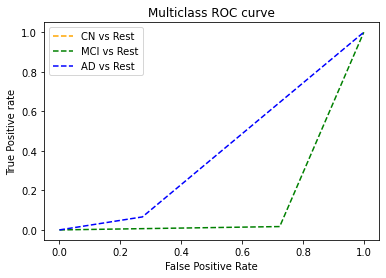

In [25]:
#DT

clf5 = DecisionTreeClassifier(criterion='gini', splitter='best', 
                              min_samples_split=2, min_samples_leaf=1, 
                               min_weight_fraction_leaf=0.0, max_features=None, 
                               random_state=None, max_leaf_nodes=None, 
                               class_weight=None, ccp_alpha=0.0)
model_evaluation(X_train2, y_train, clf5)
plot_model(clf5)

Training Score:0.9174311926605505
Cross V Score: 0.9092385392385393 +/- 0.028071403592601338
Testing Score: 0.9146341463414634
Cross & Test Diff: -0.005395607102924194
Standard Deviation: -0.192210093276073
[[55  4  0]
 [ 0 71  5]
 [ 0  5 24]]
              precision    recall  f1-score   support

           1       1.00      0.93      0.96        59
           2       0.89      0.93      0.91        76
           3       0.83      0.83      0.83        29

    accuracy                           0.91       164
   macro avg       0.91      0.90      0.90       164
weighted avg       0.92      0.91      0.92       164

Hamming Loss: 0.08536585365853659
Jaccard Score: 0.8426966292134831
MCC: 0.8635983181729626
Accuracy: 0.9146341463414634
Overall Accuracy: 0.9146341463414634
Balanced Accuracy: 0.8980000410142832
Overall Precision: 0.9173780487804878
Overall Recall: 0.9146341463414634
Overall Precision, Recall, F-measure: (0.9173780487804878, 0.9146341463414634, 0.9153006813468945, None)
A

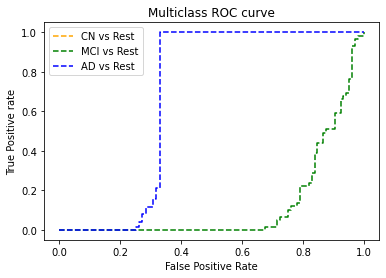

In [26]:
#LassoLogisticRegression

clf6 = linear_model.LogisticRegression(penalty='l1',dual=False, tol=0.0001, C=1.0, 
                                       fit_intercept=True, intercept_scaling=1, 
                                       class_weight=None, random_state=None, solver='liblinear', 
                                       max_iter=100, multi_class='auto', verbose=0, 
                                       warm_start=False, n_jobs=None, l1_ratio=None)
model_evaluation(X_train2, y_train, clf6)
plot_model(clf6)

Training Score:0.9311926605504587
Cross V Score: 0.9260839160839162 +/- 0.03289304196823757
Testing Score: 0.926829268292683
Cross & Test Diff: -0.0007453522087668141
Standard Deviation: -0.022659874677646012
[[57  2  0]
 [ 0 72  4]
 [ 0  6 23]]
              precision    recall  f1-score   support

           1       1.00      0.97      0.98        59
           2       0.90      0.95      0.92        76
           3       0.85      0.79      0.82        29

    accuracy                           0.93       164
   macro avg       0.92      0.90      0.91       164
weighted avg       0.93      0.93      0.93       164

Hamming Loss: 0.07317073170731707
Jaccard Score: 0.8636363636363636
MCC: 0.882610112493862
Accuracy: 0.926829268292683
Overall Accuracy: 0.926829268292683
Balanced Accuracy: 0.9021911880812493
Overall Precision: 0.9274616079494128
Overall Recall: 0.926829268292683
Overall Precision, Recall, F-measure: (0.9274616079494128, 0.926829268292683, 0.9265733740607585, None)
Aver

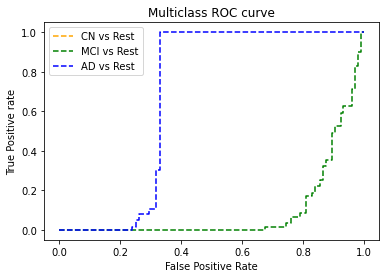

In [27]:
#RidgeLogisticRegression

clf7 = linear_model.LogisticRegression(penalty='l2',dual=False, tol=0.0001, C=1.0, fit_intercept=True, 
                                           intercept_scaling=1, class_weight=None, random_state=None, 
                                           solver='newton-cg', max_iter=100, multi_class='auto', 
                                           verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
model_evaluation(X_train2, y_train, clf7)
plot_model(clf7)

In [28]:
#PassiveAgrressive

clf8 = PassiveAggressiveClassifier(random_state=0, max_iter=1000)
model_evaluation(X_train2, y_train, clf8)

Training Score:0.7920489296636085
Cross V Score: 0.798935508935509 +/- 0.07263598466848345
Testing Score: 0.7560975609756098
Cross & Test Diff: 0.04283794795989926
Standard Deviation: 0.5897620601608851
[[29 30  0]
 [ 0 72  4]
 [ 0  6 23]]
              precision    recall  f1-score   support

           1       1.00      0.49      0.66        59
           2       0.67      0.95      0.78        76
           3       0.85      0.79      0.82        29

    accuracy                           0.76       164
   macro avg       0.84      0.74      0.75       164
weighted avg       0.82      0.76      0.75       164

Hamming Loss: 0.24390243902439024
Jaccard Score: 0.6078431372549019
MCC: 0.6359466926146123
Accuracy: 0.7560975609756098
Overall Accuracy: 0.7560975609756098
Balanced Accuracy: 0.743999097685769
Overall Precision: 0.8193315266485998
Overall Recall: 0.7560975609756098
Overall Precision, Recall, F-measure: (0.8193315266485998, 0.7560975609756098, 0.7450369090082769, None)


Average AUC: 0.9397995501441855
Log loss: 0.565702318296662


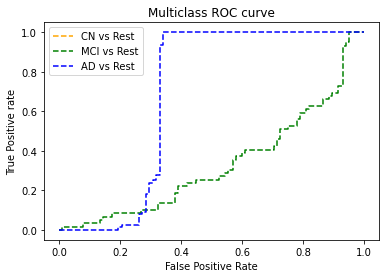

In [29]:
predict = clf8._predict_proba_lr(X_test2)

classes = ['CN', 'MCI', 'AD']

fpr = {}
tpr = {}
thresh ={}
for i in range(len(classes)):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, predict[:,i], pos_label=i)
    
auc = roc_auc_score(y_test,predict, multi_class='ovr')
print('Average AUC:', auc)
log_loss = metrics.log_loss(y_test, predict)
print(f"Log loss: {log_loss}")

plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label=classes[0] + ' vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label=classes[1] + ' vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label=classes[2] + ' vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

Training Score:0.8149847094801224
Cross V Score: 0.8235975135975138 +/- 0.05383961733681614
Testing Score: 0.8597560975609756
Cross & Test Diff: -0.03615858396346183
Standard Deviation: -0.6715980861687177
[[55  4  0]
 [ 1 75  0]
 [ 0 18 11]]
              precision    recall  f1-score   support

           1       0.98      0.93      0.96        59
           2       0.77      0.99      0.87        76
           3       1.00      0.38      0.55        29

    accuracy                           0.86       164
   macro avg       0.92      0.77      0.79       164
weighted avg       0.89      0.86      0.84       164

Hamming Loss: 0.1402439024390244
Jaccard Score: 0.7540106951871658
MCC: 0.7845014624923048
Accuracy: 0.8597560975609756
Overall Accuracy: 0.8597560975609756
Balanced Accuracy: 0.7661186133070842
Overall Precision: 0.8884714339595532
Overall Recall: 0.8597560975609756
Overall Precision, Recall, F-measure: (0.8884714339595532, 0.8597560975609756, 0.8431752217434213, None)
Ave

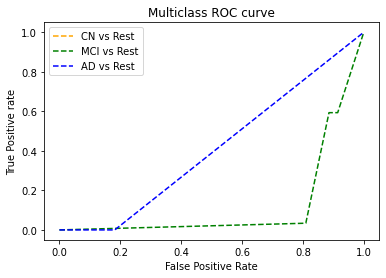

In [30]:
#SGD

clf9 = linear_model.SGDClassifier(loss='modified_huber', penalty='elasticnet', alpha=0.0001, 
                                  l1_ratio=0.15, fit_intercept=True, max_iter=1000, tol=0.001, 
                                  shuffle=True, verbose=0, epsilon=0.1, n_jobs=None, 
                                  random_state=None, learning_rate='optimal', eta0=0.0, power_t=0.5, 
                                  early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, 
                                  class_weight=None, warm_start=False, average=False)
model_evaluation(X_train2, y_train, clf9)
plot_model(clf9)

Training Score:0.8119266055045872
Cross V Score: 0.811911421911422 +/- 0.053886917502541855
Testing Score: 0.8048780487804879
Cross & Test Diff: 0.007033373130934106
Standard Deviation: 0.1305209772038332
[[56  3  0]
 [ 0 61 15]
 [ 0 14 15]]
              precision    recall  f1-score   support

           1       1.00      0.95      0.97        59
           2       0.78      0.80      0.79        76
           3       0.50      0.52      0.51        29

    accuracy                           0.80       164
   macro avg       0.76      0.76      0.76       164
weighted avg       0.81      0.80      0.81       164

Hamming Loss: 0.1951219512195122
Jaccard Score: 0.673469387755102
MCC: 0.687794274069016
Accuracy: 0.8048780487804879
Overall Accuracy: 0.8048780487804879
Balanced Accuracy: 0.7563418335435316
Overall Precision: 0.8105847404627892
Overall Recall: 0.8048780487804879
Overall Precision, Recall, F-measure: (0.8105847404627892, 0.8048780487804879, 0.8074050273467928, None)
Averag

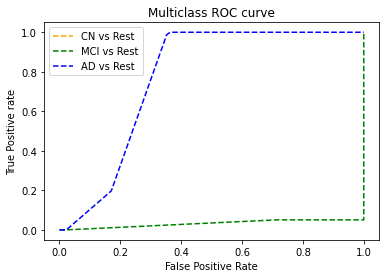

In [31]:
#BernoulliNB

clf10 = BernoulliNB(alpha=1.0, binarize=0.0, fit_prior=True, class_prior=None)
model_evaluation(X_train2, y_train, clf10)
plot_model(clf10)

Training Score:0.9097859327217125
Cross V Score: 0.9047163947163949 +/- 0.030177654887576975
Testing Score: 0.9085365853658537
Cross & Test Diff: -0.003820190649458821
Standard Deviation: -0.12659004364952997
[[57  2  0]
 [ 0 69  7]
 [ 0  6 23]]
              precision    recall  f1-score   support

           1       1.00      0.97      0.98        59
           2       0.90      0.91      0.90        76
           3       0.77      0.79      0.78        29

    accuracy                           0.91       164
   macro avg       0.89      0.89      0.89       164
weighted avg       0.91      0.91      0.91       164

Hamming Loss: 0.09146341463414634
Jaccard Score: 0.8324022346368715
MCC: 0.8538197608234757
Accuracy: 0.9085365853658537
Overall Accuracy: 0.9085365853658537
Balanced Accuracy: 0.8890332933444073
Overall Precision: 0.9105928624221308
Overall Recall: 0.9085365853658537
Overall Precision, Recall, F-measure: (0.9105928624221308, 0.9085365853658537, 0.9094021202442575, None)

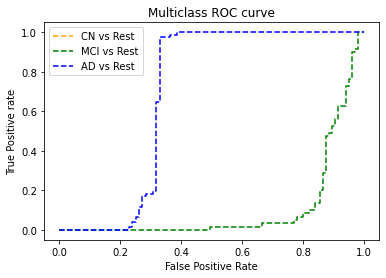

In [32]:
#GaussianNB

clf11 = GaussianNB()
model_evaluation(X_train2, y_train, clf11)
plot_model(clf11)

Training Score:0.8807339449541285
Cross V Score: 0.8551515151515152 +/- 0.04587562615597138
Testing Score: 0.8719512195121951
Cross & Test Diff: -0.0167997043606799
Standard Deviation: -0.3662010912627767
[[52  7  0]
 [ 1 72  3]
 [ 0 10 19]]
              precision    recall  f1-score   support

           1       0.98      0.88      0.93        59
           2       0.81      0.95      0.87        76
           3       0.86      0.66      0.75        29

    accuracy                           0.87       164
   macro avg       0.88      0.83      0.85       164
weighted avg       0.88      0.87      0.87       164

Hamming Loss: 0.12804878048780488
Jaccard Score: 0.772972972972973
MCC: 0.7962213728449989
Accuracy: 0.8719512195121951
Overall Accuracy: 0.8719512195121951
Balanced Accuracy: 0.827965589016375
Overall Precision: 0.880581665034759
Overall Recall: 0.8719512195121951
Overall Precision, Recall, F-measure: (0.880581665034759, 0.8719512195121951, 0.8702489643307434, None)
Average

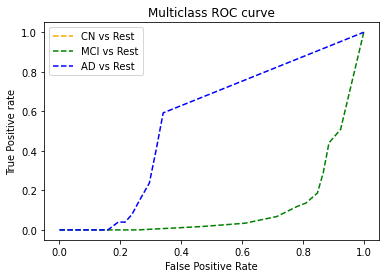

In [33]:
#KNN

clf12 = KNeighborsClassifier(n_neighbors=11, weights='uniform', 
                             algorithm='auto', leaf_size=1, p=1, 
                             metric='minkowski', metric_params=None, n_jobs=None)
model_evaluation(X_train2, y_train, clf12)
plot_model(clf12)

Training Score:0.9373088685015291
Cross V Score: 0.9321989121989122 +/- 0.03352441325054094
Testing Score: 0.9207317073170732
Cross & Test Diff: 0.011467204881838944
Standard Deviation: 0.342055349220882
[[56  3  0]
 [ 0 72  4]
 [ 0  6 23]]
              precision    recall  f1-score   support

           1       1.00      0.95      0.97        59
           2       0.89      0.95      0.92        76
           3       0.85      0.79      0.82        29

    accuracy                           0.92       164
   macro avg       0.91      0.90      0.90       164
weighted avg       0.92      0.92      0.92       164

Hamming Loss: 0.07926829268292683
Jaccard Score: 0.8531073446327684
MCC: 0.8730134554297657
Accuracy: 0.9207317073170732
Overall Accuracy: 0.9207317073170732
Balanced Accuracy: 0.896541470567125
Overall Precision: 0.922312556458898
Overall Recall: 0.9207317073170732
Overall Precision, Recall, F-measure: (0.922312556458898, 0.9207317073170732, 0.9206664908906874, None)
Average

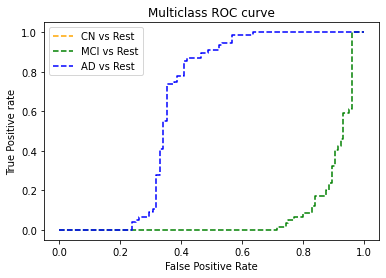

In [127]:
#LinearSVM

clf13 = SVC(C=1.0, kernel='linear', degree=3, gamma='scale', coef0=0.0, 
            shrinking=True, probability=True, tol=0.001, cache_size=200, 
            class_weight=None, verbose=False, max_iter=- 1, 
            decision_function_shape='ovr', break_ties=False, random_state=None)
model_evaluation(X_train2, y_train, clf13)
plot_model(clf13)

Training Score:0.8807339449541285
Cross V Score: 0.8628438228438229 +/- 0.03582711403902519
Testing Score: 0.9024390243902439
Cross & Test Diff: -0.039595201546421044
Standard Deviation: -1.1051741846494085
[[55  4  0]
 [ 1 72  3]
 [ 0  8 21]]
              precision    recall  f1-score   support

           1       0.98      0.93      0.96        59
           2       0.86      0.95      0.90        76
           3       0.88      0.72      0.79        29

    accuracy                           0.90       164
   macro avg       0.90      0.87      0.88       164
weighted avg       0.91      0.90      0.90       164

Hamming Loss: 0.0975609756097561
Jaccard Score: 0.8222222222222222
MCC: 0.84376335912964
Accuracy: 0.9024390243902439
Overall Accuracy: 0.9024390243902439
Balanced Accuracy: 0.8679032473058742
Overall Precision: 0.9052700348432057
Overall Recall: 0.9024390243902439
Overall Precision, Recall, F-measure: (0.9052700348432057, 0.9024390243902439, 0.90131655295224, None)
Averag

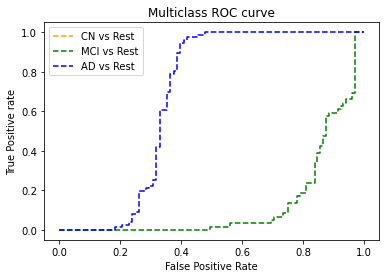

In [35]:
#RBFSVM

clf14 = SVC(C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, 
            shrinking=True, probability=True, tol=0.001, cache_size=200, 
            class_weight=None, verbose=False, max_iter=- 1, 
            decision_function_shape='ovr', break_ties=False, random_state=None)
model_evaluation(X_train2, y_train, clf14)
plot_model(clf14)

In [36]:
#Perceptron

clf15 = Perceptron(random_state=0, max_iter=1000, penalty='l1', alpha=0.0001, shuffle=True, tol=1e-3)
model_evaluation(X_train2, y_train, clf15)

Training Score:0.7798165137614679
Cross V Score: 0.7547397047397049 +/- 0.08340457685287074
Testing Score: 0.8414634146341463
Cross & Test Diff: -0.08672370989444145
Standard Deviation: -1.0397955743774805
[[55  4  0]
 [ 3 73  0]
 [ 1 18 10]]
              precision    recall  f1-score   support

           1       0.93      0.93      0.93        59
           2       0.77      0.96      0.85        76
           3       1.00      0.34      0.51        29

    accuracy                           0.84       164
   macro avg       0.90      0.75      0.77       164
weighted avg       0.87      0.84      0.82       164

Hamming Loss: 0.15853658536585366
Jaccard Score: 0.7263157894736842
MCC: 0.7513553556072499
Accuracy: 0.8414634146341463
Overall Accuracy: 0.8414634146341463
Balanced Accuracy: 0.7458524306089597
Overall Precision: 0.8682926829268293
Overall Recall: 0.8414634146341463
Overall Precision, Recall, F-measure: (0.8682926829268293, 0.8414634146341463, 0.8217114863456327, None)


Training Score:0.8929663608562691
Cross V Score: 0.8454545454545456 +/- 0.04168715977692463
Testing Score: 0.8536585365853658
Cross & Test Diff: -0.008203991130820265
Standard Deviation: -0.1967989945758184
[[50  9  0]
 [ 0 71  5]
 [ 0 10 19]]
              precision    recall  f1-score   support

           1       1.00      0.85      0.92        59
           2       0.79      0.93      0.86        76
           3       0.79      0.66      0.72        29

    accuracy                           0.85       164
   macro avg       0.86      0.81      0.83       164
weighted avg       0.87      0.85      0.85       164

Hamming Loss: 0.14634146341463414
Jaccard Score: 0.7446808510638298
MCC: 0.7676277750340685
Accuracy: 0.8536585365853658
Overall Accuracy: 0.8536585365853658
Balanced Accuracy: 0.8122801890758456
Overall Precision: 0.8653285907859078
Overall Recall: 0.8536585365853658
Overall Precision, Recall, F-measure: (0.8653285907859078, 0.8536585365853658, 0.853249642621538, None)
Av

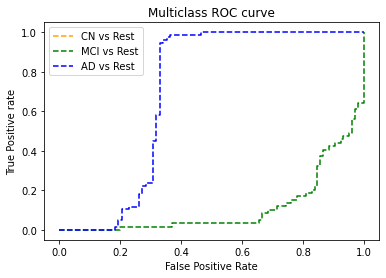

In [37]:
# MLPClassifier 

clf16 = MLPClassifier(solver='adam', alpha=1e-5, 
                      hidden_layer_sizes=(15,), random_state=1)
model_evaluation(X_train2, y_train, clf16)
plot_model(clf16)

Training Score:0.9373088685015291
Cross V Score: 0.9245532245532246 +/- 0.03237942264974739
Testing Score: 0.9207317073170732
Cross & Test Diff: 0.0038215172361514282
Standard Deviation: 0.11802301966558511
[[58  1  0]
 [ 0 71  5]
 [ 0  7 22]]
              precision    recall  f1-score   support

           1       1.00      0.98      0.99        59
           2       0.90      0.93      0.92        76
           3       0.81      0.76      0.79        29

    accuracy                           0.92       164
   macro avg       0.90      0.89      0.90       164
weighted avg       0.92      0.92      0.92       164

Hamming Loss: 0.07926829268292683
Jaccard Score: 0.8531073446327684
MCC: 0.8726237545308765
Accuracy: 0.9207317073170732
Overall Accuracy: 0.9207317073170732
Balanced Accuracy: 0.8919606878095298
Overall Precision: 0.9203257749877077
Overall Recall: 0.9207317073170732
Overall Precision, Recall, F-measure: (0.9203257749877077, 0.9207317073170732, 0.9201661416649615, None)
A

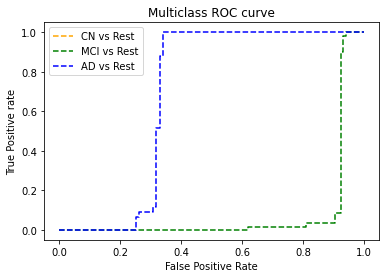

In [38]:
clf16 = MLPClassifier(solver='lbfgs', alpha=1e-5, activation='tanh', 
                      hidden_layer_sizes=(15,), random_state=1)
model_evaluation(X_train2, y_train, clf16)
plot_model(clf16)

In [39]:
import numpy as np
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.layers import Dropout
from keras.layers import Dense, Embedding, LSTM, Bidirectional
from keras.layers import Dense, RNN, LSTM, Activation, Dropout
import tensorflow as tf
from tensorflow import keras

tf.config.run_functions_eagerly(True)

In [40]:
X_train_new2 = np.resize(X_train2,(X_train2.shape[0],1,X_train2.shape[1]))
X_test_new2 = np.resize(X_test2,(X_test2.shape[0],1,X_test2.shape[1]))

In [41]:
import keras.backend as K

def precision(y_test, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_test * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_test, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_test * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_test, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [42]:
#LSTM

model=Sequential()
model.add(LSTM(128,input_shape=(1,5),activation='relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 128)            68608     
_________________________________________________________________
dropout (Dropout)            (None, 1, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1

In [43]:
model.fit(X_train_new2,y_train,epochs=120,batch_size=64)
results = model.evaluate(X_test_new2,y_test)
print(results)

Epoch 1/120
11/11 [==============================] - 2s 70ms/step - loss: 1.3251 - accuracy: 0.3879
Epoch 2/120
11/11 [==============================] - 1s 68ms/step - loss: 0.9884 - accuracy: 0.4982
Epoch 3/120
11/11 [==============================] - 1s 69ms/step - loss: 0.7292 - accuracy: 0.6370
Epoch 4/120
11/11 [==============================] - 1s 67ms/step - loss: 0.6144 - accuracy: 0.7300
Epoch 5/120
11/11 [==============================] - 1s 69ms/step - loss: 0.5105 - accuracy: 0.7568
Epoch 6/120
11/11 [==============================] - 1s 69ms/step - loss: 0.4703 - accuracy: 0.7980
Epoch 7/120
11/11 [==============================] - 1s 72ms/step - loss: 0.4541 - accuracy: 0.8117
Epoch 8/120
11/11 [==============================] - 1s 72ms/step - loss: 0.4107 - accuracy: 0.8396
Epoch 9/120
11/11 [==============================] - 1s 70ms/step - loss: 0.4000 - accuracy: 0.8205
Epoch 10/120
11/11 [==============================] - 1s 68ms/step - loss: 0.3708 - accuracy: 0.8600

In [44]:
p = model.predict(X_test_new2)
print(p)

[[1.58961200e-06 4.09237800e-05 9.80428815e-01 1.95285752e-02]
 [1.59365536e-05 4.40806756e-03 9.91252124e-01 4.32386715e-03]
 [5.88324326e-07 6.39123318e-04 9.98261869e-01 1.09844666e-03]
 [4.18106038e-06 5.43603528e-05 9.57575321e-01 4.23660502e-02]
 [2.70759174e-05 8.48940981e-04 9.75913048e-01 2.32108682e-02]
 [6.70759109e-05 3.98226548e-03 9.79645252e-01 1.63054951e-02]
 [4.10448047e-05 5.94976846e-05 3.31754804e-01 6.68144643e-01]
 [1.70489966e-05 2.94841084e-05 5.80211580e-01 4.19741869e-01]
 [4.94128257e-14 9.99952912e-01 4.71099920e-05 1.46138299e-12]
 [7.67011225e-05 5.15586056e-04 9.12186325e-01 8.72212872e-02]
 [1.48104755e-06 2.46096519e-04 9.95189905e-01 4.56243986e-03]
 [1.77251160e-04 2.31739669e-03 9.44996178e-01 5.25091998e-02]
 [2.35814447e-24 1.00000000e+00 2.83885004e-09 1.85864374e-21]
 [7.43916389e-05 7.73542910e-04 9.32921886e-01 6.62301928e-02]
 [1.60643651e-07 9.66534257e-01 3.34651433e-02 4.93712378e-07]
 [1.61338354e-09 8.28856539e-09 4.47718129e-02 9.552281

In [45]:
scores = model.evaluate(X_test_new2, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 92.68%


In [46]:
pred = model.predict(X_test_new2)
pred_y = pred.argmax(axis=-1)
cm = confusion_matrix(y_test, pred_y)

In [47]:
print(cm)

[[58  1  0]
 [ 0 72  4]
 [ 0  7 22]]


In [48]:
print("Balanced Accuracy:",balanced_accuracy_score(y_test, pred_y))
print("Overall Precision:",precision_score(y_test, pred_y, average='weighted'))
print("Overall Recall:",recall_score(y_test, pred_y, average='weighted'))
print("Overall Precision, Recall, F-measure:",precision_recall_fscore_support(y_test, pred_y, average='weighted'))

Balanced Accuracy: 0.8963466527218102
Overall Precision: 0.926454033771107
Overall Recall: 0.926829268292683
Overall Precision, Recall, F-measure: (0.926454033771107, 0.926829268292683, 0.9259120283510529, None)


In [49]:
#GRU

from keras.layers import Bidirectional, GRU, RepeatVector, Dense, TimeDistributed, Input


model = Sequential(name="GRU-Model") 
model.add(Input(shape=(X_train_new2.shape[1],X_train_new2.shape[2]), name='Input-Layer')) 
model.add(Bidirectional(GRU(units=32, activation='tanh', recurrent_activation='sigmoid', stateful=False), name='Hidden-GRU-Encoder-Layer')) 
model.add(RepeatVector(X_train.shape[1], name='Repeat-Vector-Layer')) 
model.add(Bidirectional(GRU(units=32, activation='tanh', recurrent_activation='sigmoid', stateful=False, return_sequences=True), name='Hidden-GRU-Decoder-Layer')) # Decoder Layer
model.add(TimeDistributed(Dense(units=1, activation='linear'), name='Output-Layer')) 

model.compile(optimizer='adam', 
              loss='mean_squared_error', 
              metrics=['MeanSquaredError', 'MeanAbsoluteError'], 
              loss_weights=None, 
              weighted_metrics=None, 
              run_eagerly=None, 
              steps_per_execution=None 
             )

In [50]:
history = model.fit(X_train_new2,
                    y_train,
                    batch_size=1, 
                    epochs=50,
                    verbose=1, 
                    callbacks=None, 
                    validation_split=0.2, 
                    shuffle=True, 
                    class_weight=None,
                    sample_weight=None, 
                    initial_epoch=0, 
                    steps_per_epoch=None, 
                    validation_steps=None, 
                    validation_batch_size=None, 
                    validation_freq=10,
                    max_queue_size=10, 
                    workers=1, 
                    use_multiprocessing=True, 
                   )

Epoch 1/50
523/523 [==============================] - 227s 434ms/step - loss: 0.6036 - mean_squared_error: 0.6036 - mean_absolute_error: 0.5558
Epoch 2/50
523/523 [==============================] - 241s 460ms/step - loss: 0.1723 - mean_squared_error: 0.1723 - mean_absolute_error: 0.3413
Epoch 3/50
523/523 [==============================] - 223s 426ms/step - loss: 0.1318 - mean_squared_error: 0.1318 - mean_absolute_error: 0.2862
Epoch 4/50
523/523 [==============================] - 225s 431ms/step - loss: 0.1463 - mean_squared_error: 0.1463 - mean_absolute_error: 0.2910
Epoch 5/50
523/523 [==============================] - 220s 421ms/step - loss: 0.1210 - mean_squared_error: 0.1210 - mean_absolute_error: 0.2693
Epoch 6/50
523/523 [==============================] - 220s 420ms/step - loss: 0.1147 - mean_squared_error: 0.1147 - mean_absolute_error: 0.2616
Epoch 7/50
523/523 [==============================] - 218s 418ms/step - loss: 0.0995 - mean_squared_error: 0.0995 - mean_absolute_error:

In [52]:
pred_test = model.predict(X_test_new2)
print("")
print('-------------------- Model Summary --------------------')
model.summary() 
print("")
print('-------------------- Weights and Biases --------------------')
print("")
print('-------------------- Evaluation on Training Data --------------------')
for item in history.history:
    print("Final", item, ":", history.history[item][-1])
print("")
print('-------------------- Evaluation on Test Data --------------------')
results = model.evaluate(X_test_new2, y_test)
print("")


-------------------- Model Summary --------------------
Model: "GRU-Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden-GRU-Encoder-Layer (Bi (None, 64)                7488      
_________________________________________________________________
Repeat-Vector-Layer (RepeatV (None, 43, 64)            0         
_________________________________________________________________
Hidden-GRU-Decoder-Layer (Bi (None, 43, 64)            18816     
_________________________________________________________________
Output-Layer (TimeDistribute (None, 43, 1)             65        
Total params: 26,369
Trainable params: 26,369
Non-trainable params: 0
_________________________________________________________________

-------------------- Weights and Biases --------------------
Too many parameters to print but you can use the code provided if needed

-------------------- Evaluation on Training Data ---------

In [53]:
pred_test = model.predict(X_test_new2)

test_acc = model.evaluate(X_test_new2, y_test)
print('Test accuracy:', test_acc)

scores = model.evaluate(X_test_new2, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

6/6 [==============================] - 1s 166ms/step - loss: 0.0691 - mean_squared_error: 0.0691 - mean_absolute_error: 0.1382
Test accuracy: [0.0690748393535614, 0.0690748393535614, 0.13818594813346863]
Accuracy: 6.91%


In [65]:
#AnotherOneforGRU

model = Sequential(name="GRU-Model")
model.add(Input(shape=(X_train_new2.shape[1],X_train_new2.shape[2]), name='Input-Layer'))

model.add(GRU(128, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'tanh'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "GRU-Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 128)               51840     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 51,969
Trainable params: 51,969
Non-trainable params: 0
_________________________________________________________________
None


In [66]:
model.fit(X_train_new2, y_train, epochs=50)
test_loss, test_acc = model.evaluate(X_test_new2, y_test)
print('Test accuracy:', test_acc)

Epoch 1/50
21/21 [==============================] - 1s 31ms/step - loss: 8.2669 - accuracy: 0.1719
Epoch 2/50
21/21 [==============================] - 1s 32ms/step - loss: -8.0220 - accuracy: 0.2823
Epoch 3/50
21/21 [==============================] - 1s 30ms/step - loss: -14.1143 - accuracy: 0.2476
Epoch 4/50
21/21 [==============================] - 1s 33ms/step - loss: -14.5529 - accuracy: 0.2818
Epoch 5/50
21/21 [==============================] - 1s 34ms/step - loss: -15.5858 - accuracy: 0.2468
Epoch 6/50
21/21 [==============================] - 1s 33ms/step - loss: -15.4014 - accuracy: 0.2485
Epoch 7/50
21/21 [==============================] - 1s 36ms/step - loss: -15.2931 - accuracy: 0.2735
Epoch 8/50
21/21 [==============================] - 1s 27ms/step - loss: -14.9332 - accuracy: 0.2738
Epoch 9/50
21/21 [==============================] - 1s 35ms/step - loss: -15.0466 - accuracy: 0.2682
Epoch 10/50
21/21 [==============================] - 1s 30ms/step - loss: -15.4734 - accuracy:

In [67]:
#CNN

X_train2_new = X_train2.values.reshape(X_train2.shape[0],X_train2.shape[1],1)
X_test2_new = X_test2.values.reshape(X_test2.shape[0],X_test2.shape[1],1)

In [68]:
X = X.values.reshape(X.shape[0], X.shape[1], 1)
print(X.shape)

from numpy import unique
print(unique(y))
print(unique(y).sum())

(818, 43, 1)
[  8.     9.23   9.35   9.74   9.75   9.89  10.41  10.57  10.89  11.58
  11.86  11.9   11.99  12.15  12.17  12.23  12.46  12.5   12.57  12.8
  12.91  12.95  13.1   13.11  13.18  13.21  13.29  13.39  13.45  13.46
  13.56  13.99  14.12  14.22  14.25  14.3   14.38  14.57  14.58  14.62
  14.64  14.88  14.99  15.06  15.07  15.13  15.29  15.43  15.45  15.47
  15.51  15.55  15.57  15.74  15.79  15.82  15.88  15.97  16.04  16.07
  16.11  16.13  16.23  16.31  16.32  16.68  16.69  16.71  16.74  16.76
  16.77  16.84  16.98  17.01  17.22  17.58  17.65  17.77  17.86  17.92
  18.02  18.05  18.06  18.07  18.23  18.33  18.34  18.52  18.54  18.56
  18.57  18.62  18.66  18.7   18.85  19.07  19.13  19.33  19.43  19.47
  19.67  19.69  19.71  19.72  19.86  19.88  20.13  20.29  20.33  20.37
  20.62  20.65  20.69  20.72  20.76  20.77  20.8   20.83  20.87  21.19
  21.22  21.39  21.4   21.41  21.45  21.53  21.69  21.84  21.85  22.08
  22.09  22.1   22.19  22.48  22.49  22.5   22.55  22.57  22.75  

In [70]:
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, Flatten
from keras.models import Model
from keras.models import Sequential
from keras.initializers import Constant

In [73]:
model = Sequential()
model.add(Conv1D(64, 2, activation="relu", input_shape=(5,1)))
model.add(Dense(16, activation="relu"))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(4, activation = 'softmax'))
model.compile(loss = 'sparse_categorical_crossentropy', 
     optimizer = "adam",               
              metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 4, 64)             192       
_________________________________________________________________
dense_6 (Dense)              (None, 4, 16)             1040      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2, 16)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 132       
Total params: 1,364
Trainable params: 1,364
Non-trainable params: 0
_________________________________________________________________


In [78]:
model.fit(X_train2_new, y_train, epochs = 120, batch_size=100)

p = model.predict(X_test2_new)
print(p)

Epoch 1/120
7/7 [==============================] - 0s 24ms/step - loss: 0.1964 - accuracy: 0.9159
Epoch 2/120
7/7 [==============================] - 0s 23ms/step - loss: 0.1906 - accuracy: 0.9327
Epoch 3/120
7/7 [==============================] - 0s 25ms/step - loss: 0.1910 - accuracy: 0.9297
Epoch 4/120
7/7 [==============================] - 0s 24ms/step - loss: 0.1910 - accuracy: 0.9297
Epoch 5/120
7/7 [==============================] - 0s 24ms/step - loss: 0.1914 - accuracy: 0.9251
Epoch 6/120
7/7 [==============================] - 0s 26ms/step - loss: 0.1903 - accuracy: 0.9281
Epoch 7/120
7/7 [==============================] - 0s 25ms/step - loss: 0.1898 - accuracy: 0.9343
Epoch 8/120
7/7 [==============================] - 0s 26ms/step - loss: 0.1893 - accuracy: 0.9312
Epoch 9/120
7/7 [==============================] - 0s 25ms/step - loss: 0.1895 - accuracy: 0.9297
Epoch 10/120
7/7 [==============================] - 0s 22ms/step - loss: 0.1918 - accuracy: 0.9343
Epoch 11/120
7/7 [=

In [79]:
test_loss, test_acc = model.evaluate(X_test2_new, y_test)
print('Test accuracy:', test_acc)

6/6 [==============================] - 0s 9ms/step - loss: 0.1802 - accuracy: 0.9024
Test accuracy: 0.9024389982223511


In [80]:
print("Balanced Accuracy:",balanced_accuracy_score(y_test, pred_y))
print("Overall Precision:",precision_score(y_test, pred_y, average='weighted'))
print("Overall Recall:",recall_score(y_test, pred_y, average='weighted'))
print("Overall Precision, Recall, F-measure:",precision_recall_fscore_support(y_test, pred_y, average='weighted'))

Balanced Accuracy: 0.8894331826058425
Overall Precision: 0.9229473993535116
Overall Recall: 0.9207317073170732
Overall Precision, Recall, F-measure: (0.9229473993535116, 0.9207317073170732, 0.9199796507125585, None)


In [107]:
from sklearn.ensemble import StackingClassifier

estimators = []

#Defining 5 Logistic Regression Models
model11 = LogisticRegression(penalty='l2',dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1,
                             class_weight=None, random_state=None, solver='newton-cg', max_iter=100, multi_class='auto', 
                             verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
estimators.append(('logistic1', model11))
model12 = LogisticRegression(penalty='l2',dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1,
                             class_weight=None, random_state=None, solver='newton-cg', max_iter=100, multi_class='auto', 
                             verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
estimators.append(('logistic2', model12))
model13 = LogisticRegression(penalty='l2',dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1,
                             class_weight=None, random_state=None, solver='newton-cg', max_iter=100, multi_class='auto', 
                             verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
estimators.append(('logistic3', model13))
model14 = LogisticRegression(penalty='l2',dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1,
                             class_weight=None, random_state=None, solver='newton-cg', max_iter=100, multi_class='auto', 
                             verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
estimators.append(('logistic4', model14))
model15 = LogisticRegression(penalty='l2',dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1,
                             class_weight=None, random_state=None, solver='newton-cg', max_iter=100, multi_class='auto', 
                             verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
estimators.append(('logistic5', model15))

#Defining 5 Decision Tree Classifiers
model16 = DecisionTreeClassifier(criterion='gini', splitter='best', 
                               max_depth=8, min_samples_split=8, min_samples_leaf=8, 
                               min_weight_fraction_leaf=0.0, max_features=None, 
                               random_state=None, max_leaf_nodes=None, 
                               class_weight=None, ccp_alpha=0.0)
estimators.append(('cart1', model16))
model17 = DecisionTreeClassifier(criterion='gini', splitter='best', 
                               max_depth=5, min_samples_split=2, min_samples_leaf=1, 
                               min_weight_fraction_leaf=0.0, max_features=None, 
                               random_state=None, max_leaf_nodes=None, 
                               class_weight=None, ccp_alpha=0.0)
estimators.append(('cart2', model17))
model18 = DecisionTreeClassifier(criterion='gini', splitter='best', 
                               max_depth=5, min_samples_split=2, min_samples_leaf=1, 
                               min_weight_fraction_leaf=0.0, max_features=None, 
                               random_state=None, max_leaf_nodes=None, 
                               class_weight=None, ccp_alpha=0.0)
estimators.append(('cart3', model18))
model19 = DecisionTreeClassifier(criterion='gini', splitter='best', 
                               max_depth=5, min_samples_split=2, min_samples_leaf=1, 
                               min_weight_fraction_leaf=0.0, max_features=None, 
                               random_state=None, max_leaf_nodes=None, 
                               class_weight=None, ccp_alpha=0.0)
estimators.append(('cart4', model19))
model20 = DecisionTreeClassifier(criterion='gini', splitter='best', 
                               max_depth=5, min_samples_split=2, min_samples_leaf=1, 
                               min_weight_fraction_leaf=0.0, max_features=None, 
                               random_state=None, max_leaf_nodes=None, 
                               class_weight=None, ccp_alpha=0.0)
estimators.append(('cart5', model20))

#Defining 5 Support Vector Classifiers
model21 = SVC(C=1.0, kernel='linear', degree=3, gamma='scale', coef0=0.0, 
            shrinking=True, probability=True, tol=0.001, cache_size=200, 
            class_weight=None, verbose=False, max_iter=- 1, 
            decision_function_shape='ovr', break_ties=False, random_state=None)
estimators.append(('svm1', model21))
model22 = SVC(C=1.0, kernel='linear', degree=3, gamma='scale', coef0=0.0, 
            shrinking=True, probability=True, tol=0.001, cache_size=200, 
            class_weight=None, verbose=False, max_iter=- 1, 
            decision_function_shape='ovr', break_ties=False, random_state=None)
estimators.append(('svm2', model22))
model23 = SVC(C=1.0, kernel='linear', degree=3, gamma='scale', coef0=0.0, 
            shrinking=True, probability=True, tol=0.001, cache_size=200, 
            class_weight=None, verbose=False, max_iter=- 1, 
            decision_function_shape='ovr', break_ties=False, random_state=None)
estimators.append(('svm3', model23))
model24 = SVC(C=1.0, kernel='linear', degree=3, gamma='scale', coef0=0.0, 
            shrinking=True, probability=True, tol=0.001, cache_size=200, 
            class_weight=None, verbose=False, max_iter=- 1, 
            decision_function_shape='ovr', break_ties=False, random_state=None)
estimators.append(('svm4', model24))
model25 = SVC(C=1.0, kernel='linear', degree=3, gamma='scale', coef0=0.0, 
            shrinking=True, probability=True, tol=0.001, cache_size=200, 
            class_weight=None, verbose=False, max_iter=- 1, 
            decision_function_shape='ovr', break_ties=False, random_state=None)
estimators.append(('svm5', model25))

#Defining 5 Naive Bayes classifiers
model31 = GaussianNB()
estimators.append(('nbs1', model31))
model32 = GaussianNB()
estimators.append(('nbs2', model32))
model33 = GaussianNB()
estimators.append(('nbs3', model33))
model34 = GaussianNB()
estimators.append(('nbs4', model34))
model35 = GaussianNB()
estimators.append(('nbs5', model35))

#Defining 3 Random Forest classifiers
model36 = RandomForestClassifier(n_estimators=1000, criterion='gini', 
                               max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                               min_weight_fraction_leaf=0.0, max_features='auto', 
                               max_leaf_nodes=None, min_impurity_decrease=0.0, 
                               bootstrap=True, oob_score=False, n_jobs=None, random_state=None, 
                               verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
estimators.append(('rf1', model36))
model37 = RandomForestClassifier(n_estimators=1000, criterion='gini', 
                               max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                               min_weight_fraction_leaf=0.0, max_features='auto', 
                               max_leaf_nodes=None, min_impurity_decrease=0.0, 
                               bootstrap=True, oob_score=False, n_jobs=None, random_state=None, 
                               verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
estimators.append(('rf2', model37))
model38 = RandomForestClassifier(n_estimators=1000, criterion='gini', 
                               max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                               min_weight_fraction_leaf=0.0, max_features='auto', 
                               max_leaf_nodes=None, min_impurity_decrease=0.0, 
                               bootstrap=True, oob_score=False, n_jobs=None, random_state=None, 
                               verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
estimators.append(('rf3', model38))

#Defining 3 XGB classifiers
model41 = XGBClassifier(objective='multi:softprob', num_class= 10)
estimators.append(('xg1', model41))
model42 = XGBClassifier(objective='multi:softprob', num_class= 10)
estimators.append(('xg2', model42))
model43 = XGBClassifier(objective='multi:softprob', num_class= 10)
estimators.append(('xg3', model43))

# Defining the ensemble model
ensemble = StackingClassifier(estimators, cv=10, stack_method='predict_proba', n_jobs=5, passthrough=True, verbose=0)
ensemble.fit(X_train2, y_train)
preds = ensemble.predict(X_test2)

#Confusion Matrix
cm_HybridEnsembler = confusion_matrix(y_test, preds)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           1       1.00      0.98      0.99        59
           2       0.95      0.95      0.95        76
           3       0.87      0.90      0.88        29

    accuracy                           0.95       164
   macro avg       0.94      0.94      0.94       164
weighted avg       0.95      0.95      0.95       164



In [108]:
accuracy = metrics.accuracy_score(y_test, preds)
print("Overall Accuracy:",accuracy_score(y_test, preds))

Overall Accuracy: 0.9512195121951219


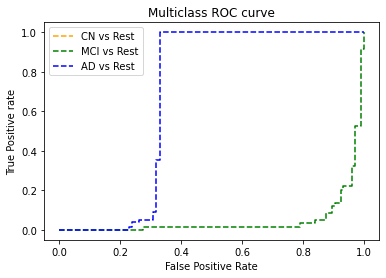

Average AUC: 0.9898598105869554
Log loss: 0.1478241006030473


In [109]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Get class probability scores
predict = ensemble.predict_proba(X_test2)

classes = ['CN', 'MCI', 'AD']

# Get ROC metrics for each class
fpr = {}
tpr = {}
thresh ={}
for i in range(len(classes)):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, predict[:,i], pos_label=i)
    
# Plot the ROC chart
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label=classes[0] + ' vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label=classes[1] + ' vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label=classes[2] + ' vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

auc = roc_auc_score(y_test,predict, multi_class='ovr')
print('Average AUC:', auc)

log_loss = metrics.log_loss(y_test, predict)
print(f"Log loss: {log_loss}")

In [110]:
    hamming_loss = metrics.hamming_loss(y_test, preds)
    jaccard = metrics.jaccard_score(y_test, preds, average='micro')
    
    accuracy = metrics.accuracy_score(y_test, preds)
    #auc_roc=metrics.roc_auc_score(y_test,preds, multi_class='ovr')
    MCC = matthews_corrcoef(y_test, preds) #Matthews correlation coefficient
    
    

    
    print(classification_report(y_test, preds))
    print(f"Hamming Loss: {hamming_loss}")
    print(f"Jaccard Score: {jaccard}")
    print(f"MCC: {MCC}")
    print(f"Accuracy: {accuracy}")
    #print(f"AUC: {auc_roc}")
    print("Overall Accuracy:",accuracy_score(y_test, preds))
    print("Balanced Accuracy:",balanced_accuracy_score(y_test, preds))
    print("Overall Precision:",precision_score(y_test, preds, average='weighted'))
    print("Overall Recall:",recall_score(y_test, preds, average='weighted'))
    print("Overall Precision, Recall, F-measure:",precision_recall_fscore_support(y_test, preds, average='weighted'))
    
    #micro, macro, weighted

              precision    recall  f1-score   support

           1       1.00      0.98      0.99        59
           2       0.95      0.95      0.95        76
           3       0.87      0.90      0.88        29

    accuracy                           0.95       164
   macro avg       0.94      0.94      0.94       164
weighted avg       0.95      0.95      0.95       164

Hamming Loss: 0.04878048780487805
Jaccard Score: 0.9069767441860465
MCC: 0.9220908684078635
Accuracy: 0.9512195121951219
Overall Accuracy: 0.9512195121951219
Balanced Accuracy: 0.9423236642160632
Overall Precision: 0.9520325203252032
Overall Recall: 0.9512195121951219
Overall Precision, Recall, F-measure: (0.9520325203252032, 0.9512195121951219, 0.9515551739611268, None)
